1. Basic information:

|weekday || time interval || number of accidents in a year|

We divide a day into 48 time slot. Each interval is 30 min.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import folium
import time
from IPython.display import display
%matplotlib inline
matplotlib.style.use('ggplot')

/Users/XueqiWang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#### Data Visualisation

Accident on Sunday


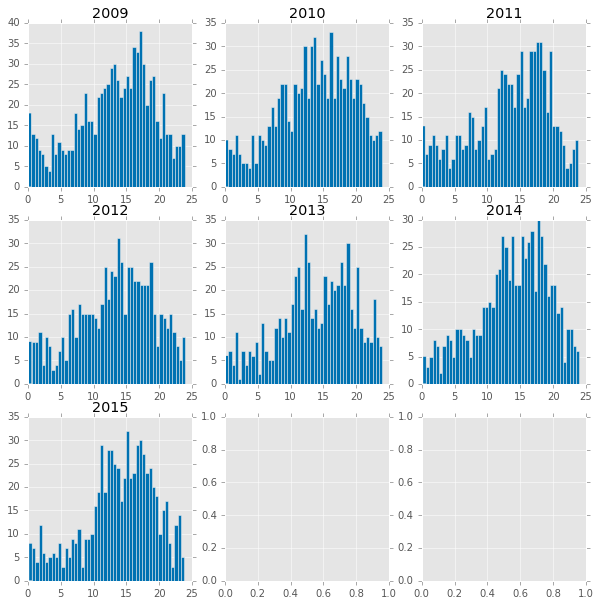

Accident on Monday


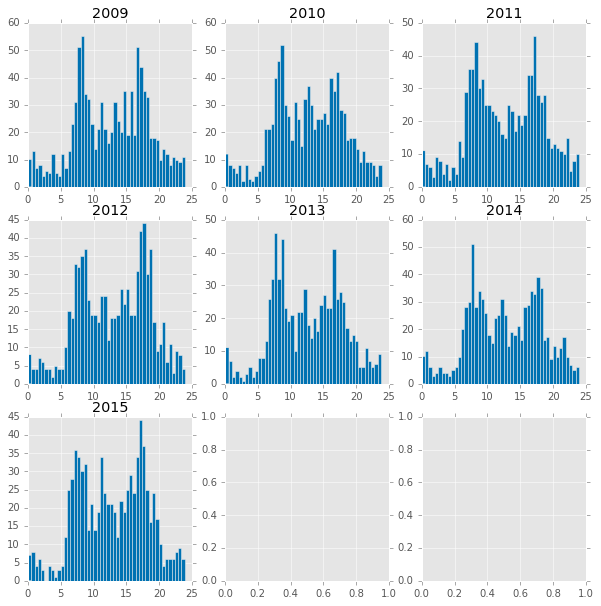

Accident on Tuesday


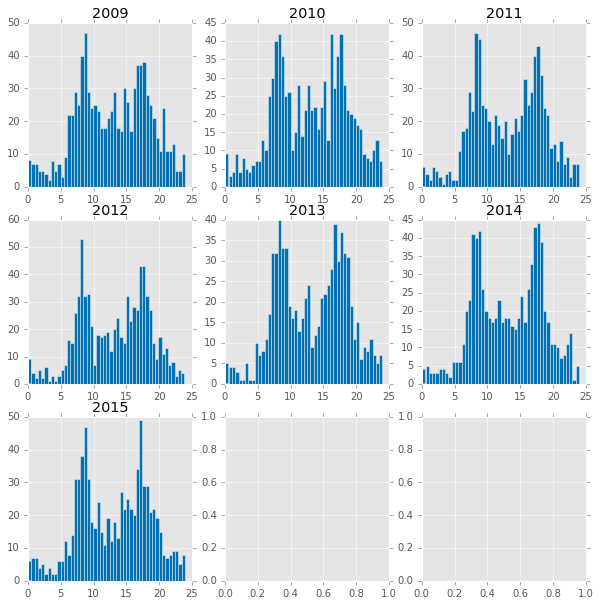

Accident on Wednesday


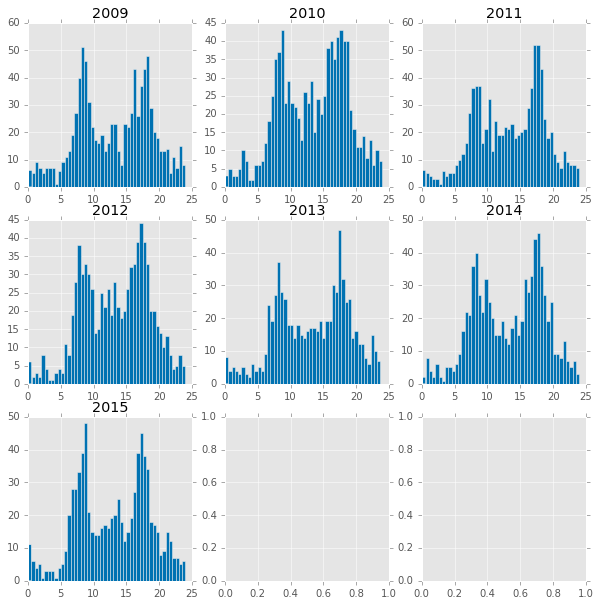

Accident on Thursday


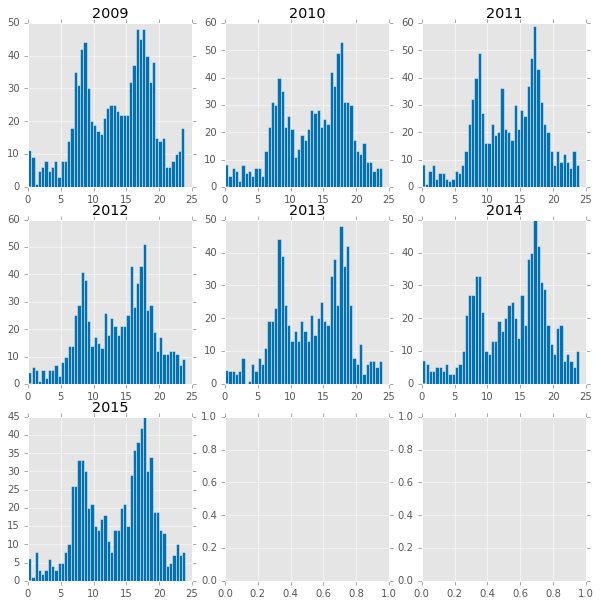

Accident on Friday


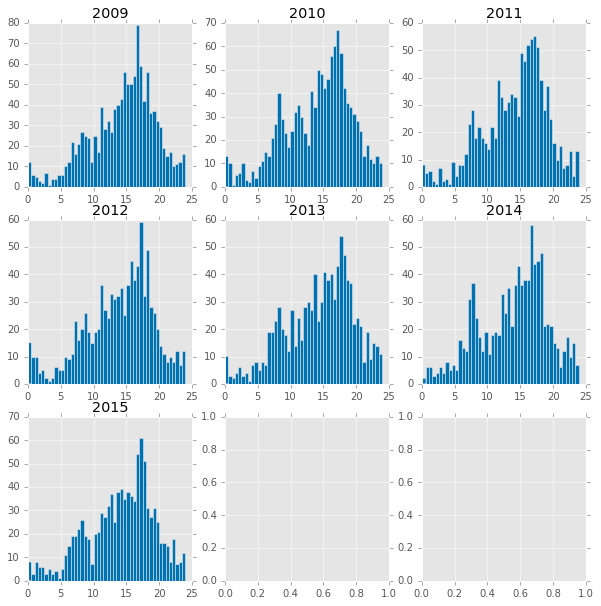

Accident on Saturday


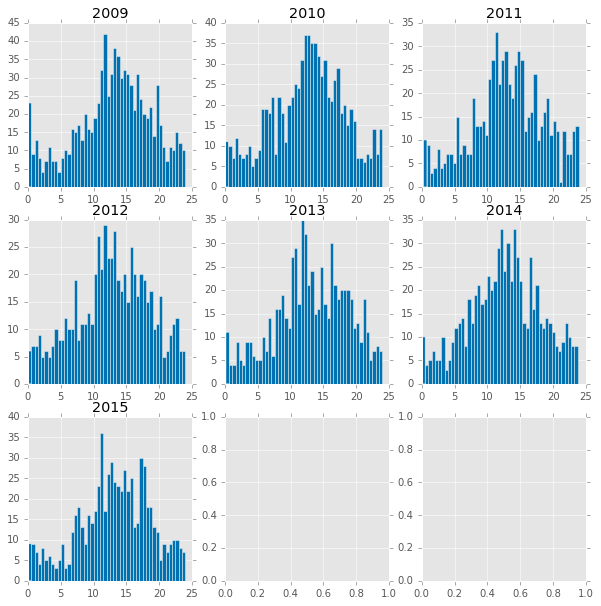

In [3]:
week = range(1,8)
day_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
for day in week:
    print "Accident on " + day_of_week[day-1]
    years = ['2009', '2010', '2011', '2012', '2013', '2014', '2015']
    nfig = 0
    fig, axes = plt.subplots(nrows=3, ncols=3)
    for year in years:
        df = pd.read_csv('data2/Accidents_'+ year +'.csv',low_memory=False)
        df = df[df['Day_of_Week']==day]
        times = df['Time'].values
        n = len(times)
        hour = pd.Series([0.0]*n)
        i = 0
        for t in times:
            hm = t.split(':')
            hour[i] = float(hm[0]) + float(hm[1])/60
            i+=1
        hour.hist(bins = 48, ax=axes[int(nfig/3), nfig%3], figsize = (10,10),color = '#0072B2')
        axes[int(nfig/3), nfig%3].set_title(year);
        nfig+=1
    plt.show()

** Abstract related data (weekday, time, number of accident) -> save as numpy array **

In [154]:
years = ['2009', '2010', '2011', '2012', '2013', '2014', '2015']
day_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
week = range(1,8)
result = np.zeros(shape = (2352, 3))
i = 0
for year in years:
    df = pd.read_csv('data2/Accidents_'+ year +'.csv',low_memory=False)
    for day in week:
        df_w = df[df['Day_of_Week'] == day] # select weekday
        result[i : i+48, 0] = day                # save weekday information
        
        times = df_w['Time'].values
        n = len(times)
        time_series = pd.Series([0.0]*n)
        j = 0
        for t in times:
            hm = t.split(':')
            if int(hm[1]) <= 30:
                time_series[j] = int(hm[0]) + 0.5
            else:
                time_series[j] = int(hm[0]) + 1.0
            j += 1
        
        count = time_series.value_counts().reindex(np.linspace(0.5, 24, 48))
        result[i : i+48 , 1] = count.index   # time interval
        result[i : i+48 , 2] = count.values  # accident counting 
        
        i += 48 # update the number of weekdays
result = np.nan_to_num(result)
np.save('data4/num_accident_2009-2015.npy', result)

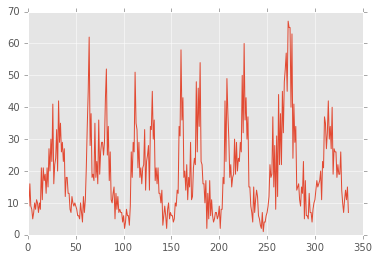

In [155]:
data = np.load('data4/num_accident_2009-2015.npy')
plt.plot(data[0:336, -1])

### Dataset 2 -> for nonlear regression

Encode weekday and time using sin() and cos() function. 

Normalise the number of accident.

In [157]:
import math
npdata = np.load('data4/num_accident_2009-2015.npy')
newdata = np.zeros(shape = (2352, 5))
newdata[:, 0] = np.sin(2* math.pi * npdata[:,0]/7.0)
newdata[:, 1] = np.cos(2* math.pi * npdata[:,0]/7.0)
newdata[:, 2] = np.sin(2* math.pi * npdata[:,1]/24.0)
newdata[:, 3] = np.sin(2* math.pi * npdata[:,1]/24.0)
d = npdata[:,-1]
mean = np.mean(d)
std = np.std(d)
newdata[:, 4] = (d - mean)/std
print ("mean: {:.6f}".format(mean))
print ('standard deviation: {:.6f}'.format(std))
np.save('data4/num_accident_tri_2009-2015.npy', newdata)

mean: 17.499150
standard deviation: 12.369007


Neural network

* sigmoid mlp, 
* 3 hidden layer

In [2]:
from __future__ import print_function

import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T

import lasagne

# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.
# Notice that this function returns only mini-batches of size `batchsize`.
# If the size of the data is not a multiple of `batchsize`, it will not
# return the last (remaining) mini-batch.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


# ############################## Main program ################################
# Everything else will be handled in our main program now. We could pull out
# more functions to better separate the code, but it wouldn't make it any
# easier to read.

def train_mlp(model='mlp', num_epochs=50, learning_rate=0.001, train_shuffle=True, batchsize = 336):
    # Load the dataset
    print("Loading data...")
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

    # Prepare Theano variables for inputs and targets
    input_var = T.tensor3('inputs')
    target_var = T.matrix('targets')

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    
    network = build_mlp(input_var)
    

    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.squared_error(prediction, target_var)
    loss = loss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=learning_rate, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.squared_error(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    
    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast = True)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], test_loss, allow_input_downcast = True)

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batchsize = batchsize, shuffle=train_shuffle):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, y_val.shape[0], shuffle=False):
            inputs, targets = batch
            #print (inputs.shape, targets.shape)
            err = val_fn(inputs, targets)
            val_err += err
            val_batches += 1
        
        # save the loss value
        train_loss[epoch] = train_err / train_batches
        val_loss[epoch] = val_err / val_batches
        
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_loss[epoch]))
        print("  validation loss:\t\t{:.6f}".format(val_loss[epoch]))    

    # After training, we compute and print the test error:
    test_err = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, y_test.shape[0], shuffle=False):
        inputs, targets = batch
        err = val_fn(inputs, targets)
        test_err += err
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    return network, train_loss, val_loss
# Optionally, you could now dump the network weights to a file like this:
# np.savez('model.npz', *lasagne.layers.get_all_param_values(network))
#
# And load them again later on like this:
# with np.load('model.npz') as f:
#     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
# lasagne.layers.set_all_param_values(network, param_values)

/Users/XueqiWang/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [173]:
def load_dataset():
    npdata = np.load('data4/num_accident_tri_2009-2015.npy')
    npdata = npdata.astype(np.float32)
    X_train, X_val = npdata[0:1680, 0:4].reshape(1680,1,4), npdata[1680:2016, 0:4].reshape(336,1,4)
    y_train, y_val = npdata[0:1680, 4].reshape(1680,1), npdata[1680:2016, 4].reshape(336,1)
    x_test, y_test = npdata[2016:2352, 0:4].reshape(336,1,4), npdata[1680:2016, 4].reshape(336,1 )
    #print (X_train.shape, y_train.shape, X_val.shape, y_val.shape, npdata.shape)
    return X_train, y_train, X_val, y_val, x_test, y_test


def build_mlp(input_var=None, units = 10):
    # This creates an MLP of one hidden layers of xx units each, followed by
    
    # Input layer, specifying the expected input shape of the network
    l_in = lasagne.layers.InputLayer(shape=(None,1,4),
                                     input_var=input_var)

    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
    l_hid3 = lasagne.layers.DenseLayer(
            l_hid2, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())

    l_out = lasagne.layers.DenseLayer(
            l_hid3, num_units=1,
            nonlinearity=lasagne.nonlinearities.linear)
    return l_out

network, train_loss, val_loss = train_mlp(num_epochs=8000, learning_rate=0.02)    

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 8000 took 0.003s
  training loss:		1.042544
  validation loss:		0.925748
Epoch 2 of 8000 took 0.003s
  training loss:		1.039084
  validation loss:		0.901383
Epoch 3 of 8000 took 0.003s
  training loss:		1.036139
  validation loss:		0.901461
Epoch 4 of 8000 took 0.003s
  training loss:		1.035445
  validation loss:		0.903262
Epoch 5 of 8000 took 0.003s
  training loss:		1.032932
  validation loss:		0.900865
Epoch 6 of 8000 took 0.003s
  training loss:		1.032139
  validation loss:		0.899292
Epoch 7 of 8000 took 0.003s
  training loss:		1.031559
  validation loss:		0.899748
Epoch 8 of 8000 took 0.003s
  training loss:		1.028955
  validation loss:		0.899838
Epoch 9 of 8000 took 0.003s
  training loss:		1.029116
  validation loss:		0.899904
Epoch 10 of 8000 took 0.003s
  training loss:		1.026309
  validation loss:		0.898386
Epoch 11 of 8000 took 0.003s
  training loss:		1.025084
  validation loss:		0.89

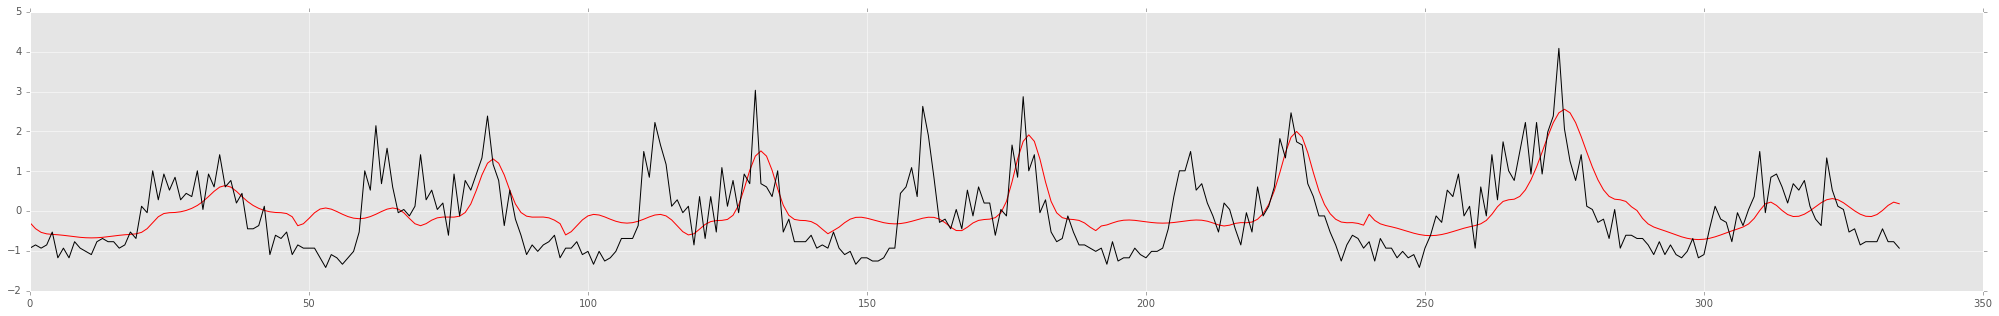

In [171]:
npdata = np.load('data4/num_accident_tri_2009-2015.npy')
output = lasagne.layers.get_output(network, inputs= npdata[2016:2352, 0:4].reshape(336,1,4)).eval()
prediction = np.zeros(shape = (336,3))
olddata = np.load('data4/num_accident_2009-2015.npy')
prediction[:, 0:2] = olddata[2016:2352, 0:2]
prediction[:,2] = output.reshape(336)
plt.figure(figsize = (35,5))
plt.plot(prediction[0:336,2], color='r')
plt.plot(npdata[2016:2353, -1], color = 'k')

** LSTM **


In [ ]:
def load_dataset():
    npdata = np.load('data4/num_accident_tri_2009-2015.npy')
    npdata = npdata.astype(np.float32)
    X_train, X_val = npdata[0:1680, 0:4].reshape(1680,1,4), npdata[1680:2016, 0:4].reshape(336,1,4)
    y_train, y_val = npdata[0:1680, 4].reshape(1680,1), npdata[1680:2016, 4].reshape(336,1)
    x_test, y_test = npdata[2016:2352, 0:4].reshape(336,1,4), npdata[1680:2016, 4].reshape(336,1 )
    #print (X_train.shape, y_train.shape, X_val.shape, y_val.shape, npdata.shape)
    return X_train, y_train, X_val, y_val, x_test, y_test


def build_mlp(input_var=None, units = 5):
    
    # Input layer, specifying the expected input shape of the network
    l_in = lasagne.layers.InputLayer(shape=(None,1,4),
                                     input_var=input_var)

    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.LSTMLayer(
            l_in, num_units = units)
    
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
    l_hid3 = lasagne.layers.DenseLayer(
            l_hid2, num_units = units*2,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
    l_out = lasagne.layers.DenseLayer(
            l_hid3, num_units=1,
            nonlinearity=lasagne.nonlinearities.linear)

    return l_out


network, train_loss, val_loss = train_mlp(num_epochs= 8000, learning_rate=0.03, train_shuffle = False)
np.savez('model/model1.npz', *lasagne.layers.get_all_param_values(network))

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 8000 took 0.011s
  training loss:		1.120094
  validation loss:		0.988870
Epoch 2 of 8000 took 0.010s
  training loss:		1.120714
  validation loss:		0.906907
Epoch 3 of 8000 took 0.010s
  training loss:		1.049225
  validation loss:		0.900182
Epoch 4 of 8000 took 0.010s
  training loss:		1.044422
  validation loss:		0.899709
Epoch 5 of 8000 took 0.011s
  training loss:		1.049001
  validation loss:		0.899584
Epoch 6 of 8000 took 0.010s
  training loss:		1.044873
  validation loss:		0.898945
Epoch 7 of 8000 took 0.010s
  training loss:		1.045775
  validation loss:		0.898616
Epoch 8 of 8000 took 0.010s
  training loss:		1.044995
  validation loss:		0.898224
Epoch 9 of 8000 took 0.010s
  training loss:		1.044508
  validation loss:		0.897842
Epoch 10 of 8000 took 0.011s
  training loss:		1.044127
  validation loss:		0.897473
Epoch 11 of 8000 took 0.012s
  training loss:		1.043645
  validation loss:		0.89

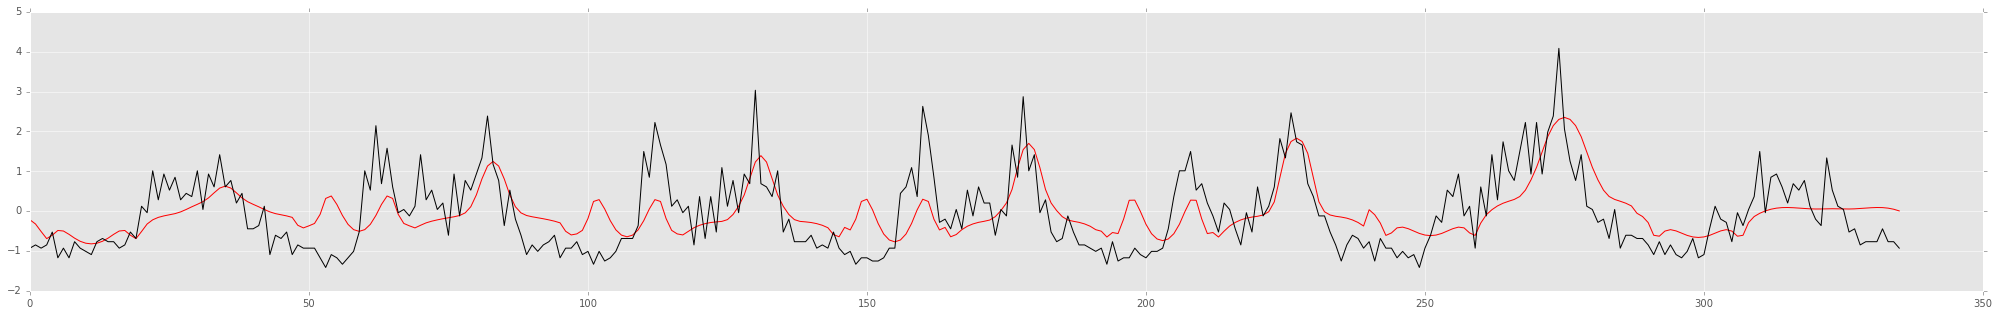

In [189]:
with np.load('model/model1.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)

npdata = np.load('data4/num_accident_tri_2009-2015.npy')
output = lasagne.layers.get_output(network, inputs= npdata[2016:2352, 0:4].reshape(336,1,4)).eval()
prediction = np.zeros(shape = (336,3))
olddata = np.load('data4/num_accident_2009-2015.npy')
prediction[:, 0:2] = olddata[2016:2352, 0:2]
prediction[:,2] = output.reshape(336)

plt.figure(figsize = (35,5))
plt.plot(prediction[0:336,2], color='r')
plt.plot(npdata[2016:2353, -1], color = 'k')

### Data set 3

Encode weekday as one-hot style

In [190]:
data1 = np.load('data4/num_accident_2009-2015.npy')
data2 = np.load('data4/num_accident_tri_2009-2015.npy')
newdata = np.zeros(shape = (2352,10))
newdata[:, 7:10] = data2[:, -3:]
i = 0
while i<7:
    j=0
    while j<7:
        start = i*336+j*48
        newdata[start : start+48, j] = 1
        j+=1
    i+=1
np.save('data4/num_accident_tri_OHweekday_2009-2015.npy', newdata)

NN on dataset 3

In [202]:
def load_dataset():
    npdata = np.load('data4/num_accident_tri_OHweekday_2009-2015.npy')
    npdata = npdata.astype(np.float32)
    X_train, X_val = npdata[0:1680, 0:-1].reshape(1680,1,9), npdata[1680:2016, 0:-1].reshape(336,1,9)
    y_train, y_val = npdata[0:1680, -1].reshape(1680,1), npdata[1680:2016, -1].reshape(336,1)
    x_test, y_test = npdata[2016:2352, 0:-1].reshape(336,1,9), npdata[1680:2016, -1].reshape(336,1 )
    #print (X_train.shape, y_train.shape, X_val.shape, y_val.shape, npdata.shape)
    return X_train, y_train, X_val, y_val, x_test, y_test


def build_mlp(input_var=None, units = 10):
    
    # Input layer, specifying the expected input shape of the network
    l_in = lasagne.layers.InputLayer(shape=(None,1,9),
                                     input_var=input_var)

    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
        
    l_out = lasagne.layers.DenseLayer(
            l_hid1, num_units=1,
            nonlinearity=lasagne.nonlinearities.linear)

    return l_out

network, train_loss, val_loss = train_mlp(num_epochs=6000, learning_rate=0.03)
np.savez('model/model2.npz', *lasagne.layers.get_all_param_values(network))

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 6000 took 0.002s
  training loss:		1.198821
  validation loss:		0.999647
Epoch 2 of 6000 took 0.002s
  training loss:		0.961762
  validation loss:		0.791456
Epoch 3 of 6000 took 0.001s
  training loss:		0.899015
  validation loss:		0.785653
Epoch 4 of 6000 took 0.001s
  training loss:		0.880436
  validation loss:		0.784428
Epoch 5 of 6000 took 0.002s
  training loss:		0.876317
  validation loss:		0.786581
Epoch 6 of 6000 took 0.001s
  training loss:		0.869740
  validation loss:		0.781198
Epoch 7 of 6000 took 0.001s
  training loss:		0.866016
  validation loss:		0.772179
Epoch 8 of 6000 took 0.001s
  training loss:		0.864260
  validation loss:		0.770478
Epoch 9 of 6000 took 0.001s
  training loss:		0.861866
  validation loss:		0.767779
Epoch 10 of 6000 took 0.001s
  training loss:		0.859402
  validation loss:		0.765782
Epoch 11 of 6000 took 0.002s
  training loss:		0.858299
  validation loss:		0.76

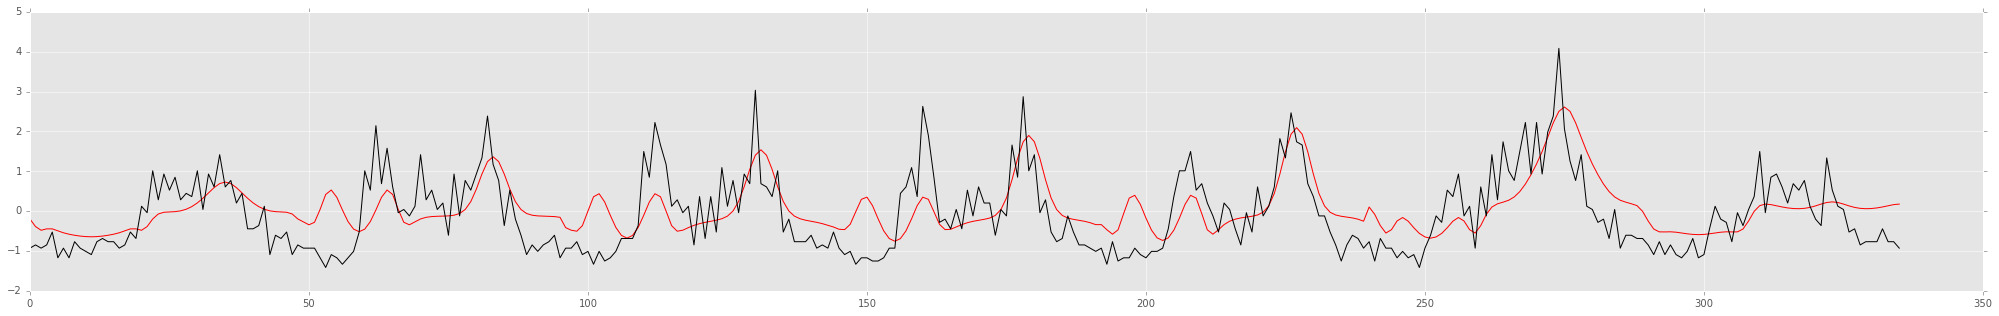

In [201]:
with np.load('model/model2.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)

npdata = np.load('data4/num_accident_tri_OHweekday_2009-2015.npy')
output = lasagne.layers.get_output(network, inputs= npdata[2016:2352, 0:-1].reshape(336,1,9)).eval()
prediction = np.zeros(shape = (336,3))
olddata = np.load('data4/num_accident_2009-2015.npy')
prediction[:, 0:2] = olddata[2016:2352, 0:2]
prediction[:,2] = output.reshape(336)

plt.figure(figsize = (35,5))
plt.plot(prediction[0:336,2], color='r')
plt.plot(npdata[2016:2353, -1], color = 'k')

Train model for weekdays seperately

In [5]:
# Abstract Sunday data
olddata = np.load('data4/num_accident_tri_2009-2015.npy')
newdata = np.zeros(shape = (336,3))
i = 0
j = 0
while j<7:
    newdata[j*48:j*48+48, :] = olddata[i:i+48, -3:]
    j+=1
    i+=336

In [13]:
def load_dataset():
    npdata = newdata
    npdata = npdata.astype(np.float32)
    X_train, X_val = npdata[0:240, 0:2].reshape(240,1,2), npdata[240:288, 0:2].reshape(48,1,2)
    y_train, y_val = npdata[0:240, 2].reshape(240,1), npdata[240:288, 2].reshape(48,1)
    x_test, y_test = npdata[288:336, 0:2].reshape(48,1,2), npdata[288:336, 2].reshape(48,1)
    #print (X_train.shape, y_train.shape, X_val.shape, y_val.shape, npdata.shape)
    return X_train, y_train, X_val, y_val, x_test, y_test


def build_mlp(input_var=None, units = 10, num_features = 2):
    
    # Input layer, specifying the expected input shape of the network
    l_in = lasagne.layers.InputLayer(shape=(None,1,num_features),
                                     input_var=input_var)

    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
#     l_hid3 = lasagne.layers.DenseLayer(
#             l_hid2, num_units = units*2,
#             nonlinearity=lasagne.nonlinearities.sigmoid,
#             W=lasagne.init.GlorotUniform())
    
    l_out = lasagne.layers.DenseLayer(
            l_hid2, num_units=1,
            nonlinearity=lasagne.nonlinearities.linear)

    return l_out


network, train_loss, val_loss = train_mlp(num_epochs=5000, learning_rate=0.005, train_shuffle = False, batchsize = 48)

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 5000 took 0.001s
  training loss:		0.462978
  validation loss:		0.456357
Epoch 2 of 5000 took 0.001s
  training loss:		0.459494
  validation loss:		0.449731
Epoch 3 of 5000 took 0.001s
  training loss:		0.456593
  validation loss:		0.443128
Epoch 4 of 5000 took 0.001s
  training loss:		0.454607
  validation loss:		0.438780
Epoch 5 of 5000 took 0.001s
  training loss:		0.452376
  validation loss:		0.436103
Epoch 6 of 5000 took 0.001s
  training loss:		0.449528
  validation loss:		0.433850
Epoch 7 of 5000 took 0.001s
  training loss:		0.446345
  validation loss:		0.431076
Epoch 8 of 5000 took 0.001s
  training loss:		0.443118
  validation loss:		0.427624
Epoch 9 of 5000 took 0.001s
  training loss:		0.440022
  validation loss:		0.423893
Epoch 10 of 5000 took 0.001s
  training loss:		0.437087
  validation loss:		0.420282
Epoch 11 of 5000 took 0.001s
  training loss:		0.434240
  validation loss:		0.41

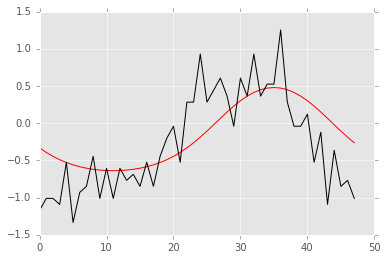

In [18]:
npdata = newdata
output = lasagne.layers.get_output(network, inputs= npdata[288:336, 0:-1].reshape(48,1,2)).eval()
prediction = np.zeros(shape = (48,3))
olddata = np.load('data4/num_accident_2009-2015.npy')
prediction[:, 0:2] = olddata[2016:2064, 0:2]
prediction[:,2] = output.reshape(48)

plt.figure()
plt.plot(prediction[0:48,2], color = 'r')
plt.plot(npdata[240:288, -1], color = 'k')
#plt.bar(olddata[2016:2064, -1])

7 years Sunday data

<function matplotlib.pyplot.show>

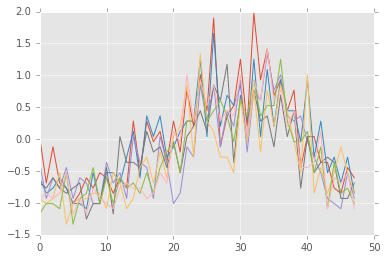

In [21]:
plt.figure()
i = 0
while i<=288:
    plt.plot(npdata[i:i+48,-1])
    i += 48
plt.show

#### Monday

In [93]:
# Abstract Monday data
olddata = np.load('data4/num_accident_tri_2009-2015.npy')
newdata = np.zeros(shape = (336,3))
i = 48
j = 0
while j<7:
    newdata[j*48:j*48+48, :] = olddata[i:i+48, -3:]
    j+=1
    i+=336

In [91]:
def load_dataset():
    npdata = newdata
    npdata = npdata.astype(np.float32)
    X_train, X_val = npdata[0:240, 0:2].reshape(240,1,2), npdata[240:288, 0:2].reshape(48,1,2)
    y_train, y_val = npdata[0:240, 2].reshape(240,1), npdata[240:288, 2].reshape(48,1)
    x_test, y_test = npdata[288:336, 0:2].reshape(48,1,2), npdata[288:336, 2].reshape(48,1)
    #print (X_train.shape, y_train.shape, X_val.shape, y_val.shape, npdata.shape)
    return X_train, y_train, X_val, y_val, x_test, y_test


def build_mlp(input_var=None, units = 20, num_features = 2):
    
    # Input layer, specifying the expected input shape of the network
    l_in = lasagne.layers.InputLayer(shape=(None,1,num_features),
                                     input_var=input_var)

    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
#     l_hid3 = lasagne.layers.DenseLayer(
#             l_hid2, num_units = units,
#             nonlinearity=lasagne.nonlinearities.sigmoid,
#             W=lasagne.init.GlorotUniform())
#     l_hid4 = lasagne.layers.DenseLayer(
#             l_hid3, num_units = units,
#             nonlinearity=lasagne.nonlinearities.sigmoid,
#             W=lasagne.init.GlorotUniform())
      
    l_out = lasagne.layers.DenseLayer(
            l_hid2, num_units=1,
            nonlinearity=lasagne.nonlinearities.linear)

    return l_out


network, train_loss, val_loss = train_mlp(num_epochs=5000, learning_rate=0.02, train_shuffle = False, batchsize = 48)

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 5000 took 0.001s
  training loss:		1.197400
  validation loss:		0.886998
Epoch 2 of 5000 took 0.001s
  training loss:		1.019406
  validation loss:		0.894158
Epoch 3 of 5000 took 0.001s
  training loss:		1.045522
  validation loss:		0.872223
Epoch 4 of 5000 took 0.001s
  training loss:		1.028503
  validation loss:		0.872971
Epoch 5 of 5000 took 0.001s
  training loss:		1.027288
  validation loss:		0.869181
Epoch 6 of 5000 took 0.001s
  training loss:		1.023250
  validation loss:		0.866679
Epoch 7 of 5000 took 0.001s
  training loss:		1.019786
  validation loss:		0.864428
Epoch 8 of 5000 took 0.001s
  training loss:		1.016823
  validation loss:		0.862374
Epoch 9 of 5000 took 0.001s
  training loss:		1.014011
  validation loss:		0.860672
Epoch 10 of 5000 took 0.001s
  training loss:		1.011583
  validation loss:		0.859213
Epoch 11 of 5000 took 0.001s
  training loss:		1.009420
  validation loss:		0.85

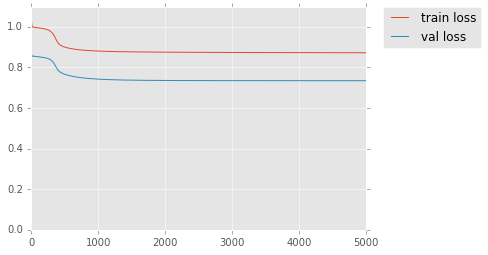

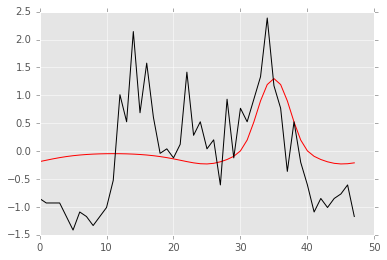

In [92]:
epoch = range(5000)
plt.figure()
plt.plot(epoch, train_loss, label = 'train loss')
plt.plot(epoch, val_loss, label = 'val loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim((0,1.1))
npdata = newdata
output = lasagne.layers.get_output(network, inputs= npdata[288:336, 0:-1].reshape(48,1,2)).eval()
prediction = np.zeros(shape = (48,3))
prediction[:, 0:2] = olddata[2016:2064, 0:2]
prediction[:,2] = output.reshape(48)

plt.figure()
plt.plot(prediction[0:48,2], color = 'r')
plt.plot(npdata[288:336, -1], color = 'k')
#plt.bar(olddata[2016:2064, -1])

<function matplotlib.pyplot.show>

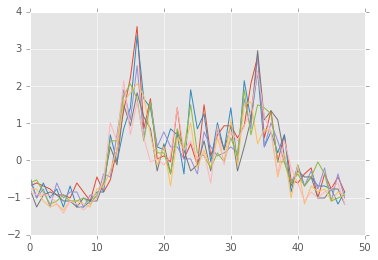

In [52]:
plt.figure()
i = 0
while i<=288:
    plt.plot(npdata[i:i+48,-1])
    i += 48
plt.show

### polynomial fitting - Monday

/Users/XueqiWang/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


test loss:			0.243350


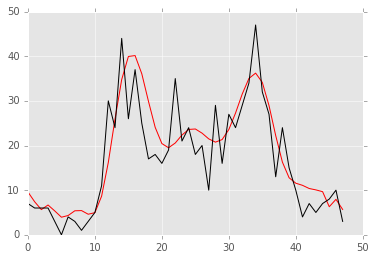

In [14]:
olddata = np.load('data4/num_accident_2009-2015.npy')
# abstract Monday data
newdata = np.zeros(shape = (336,3))
i = 48
j = 0
while j<7:
    newdata[j*48:j*48+48, :] = olddata[i:i+48, -3:]
    j+=1
    i+=336

x = newdata[0:288, 1]
y = newdata[0:288, 2]
z = np.polyfit(x, y, 25)
fitline = np.poly1d(z)

plt.figure()
plt.plot(fitline(newdata[288:336, 1]), color = 'r')
plt.plot(newdata[288:336, -1], color = 'k')

# compute test loss
pre = (fitline(newdata[288:336, 1]) - 17.49915)/12.369007
ob = (newdata[288:336, -1] - 17.49915)/12.369007
test_err = (pre - ob)**2
test_err = test_err.mean()
print ('test loss:\t\t\t{:.6f}'.format(test_err))

#### Gaussian normalised time + normalised label + neural network

In [94]:
import math
npdata = np.load('data4/num_accident_2009-2015.npy')
newdata = np.zeros(shape = (2352, 3))
# normalised all column (week, time, count)
for i in range(3):
    d = npdata[:,i]
    mean = np.mean(d)
    std = np.std(d)
    newdata[:, i] = (d - mean)/std
    print ("mean: {:.6f}".format(mean))
    print ('standard deviation: {:.6f}'.format(std))
#np.save('data4/num_accident_tri_2009-2015.npy', newdata)

mean: 4.000000
standard deviation: 2.000000
mean: 12.250000
standard deviation: 6.926700
mean: 17.499150
standard deviation: 12.369007


In [95]:
# Abstract Monday data
olddata = newdata
newdata = np.zeros(shape = (336,3))
i = 48
j = 0
while j<7:
    newdata[j*48:j*48+48, :] = olddata[i:i+48, :]
    j+=1
    i+=336

Denselayer

In [125]:
def load_dataset():
    npdata = newdata
    npdata = npdata.astype(np.float32)
    X_train, X_val = npdata[0:240, 1].reshape(240,1,1), npdata[240:288, 1].reshape(48,1,1)
    y_train, y_val = npdata[0:240, 2].reshape(240,1), npdata[240:288, 2].reshape(48,1)
    x_test, y_test = npdata[288:336, 1].reshape(48,1,1), npdata[288:336, 2].reshape(48,1)
    #print (X_train.shape, y_train.shape, X_val.shape, y_val.shape, npdata.shape)
    return X_train, y_train, X_val, y_val, x_test, y_test


def build_mlp(input_var=None, units = 15, num_features = 1):
    
    # Input layer, specifying the expected input shape of the network
    l_in = lasagne.layers.InputLayer(shape=(None,1,num_features),
                                     input_var=input_var)

    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
    l_hid3 = lasagne.layers.DenseLayer(
            l_hid2, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
      
    l_out = lasagne.layers.DenseLayer(
            l_hid3, num_units=1,
            nonlinearity=lasagne.nonlinearities.linear)

    return l_out


network, train_loss, val_loss = train_mlp(num_epochs=2000, learning_rate=0.02, train_shuffle = False, batchsize = 48)

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 2000 took 0.001s
  training loss:		1.268010
  validation loss:		0.941109
Epoch 2 of 2000 took 0.001s
  training loss:		1.048918
  validation loss:		0.893021
Epoch 3 of 2000 took 0.001s
  training loss:		1.049215
  validation loss:		0.883827
Epoch 4 of 2000 took 0.001s
  training loss:		1.046747
  validation loss:		0.880062
Epoch 5 of 2000 took 0.001s
  training loss:		1.038172
  validation loss:		0.882701
Epoch 6 of 2000 took 0.001s
  training loss:		1.042059
  validation loss:		0.881243
Epoch 7 of 2000 took 0.001s
  training loss:		1.040817
  validation loss:		0.881200
Epoch 8 of 2000 took 0.001s
  training loss:		1.040449
  validation loss:		0.881202
Epoch 9 of 2000 took 0.001s
  training loss:		1.040574
  validation loss:		0.880940
Epoch 10 of 2000 took 0.001s
  training loss:		1.040261
  validation loss:		0.880834
Epoch 11 of 2000 took 0.001s
  training loss:		1.040125
  validation loss:		0.88

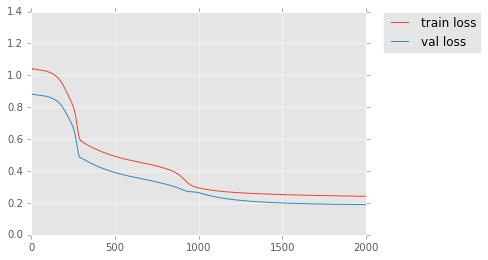

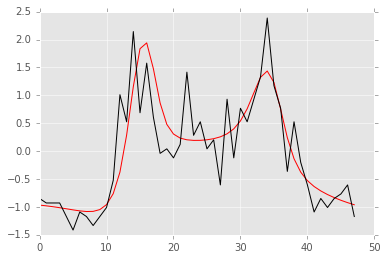

In [126]:
epoch = range(2000)
plt.figure()
plt.plot(epoch, train_loss, label = 'train loss')
plt.plot(epoch, val_loss, label = 'val loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim((0,1.1))
npdata = newdata
output = lasagne.layers.get_output(network, inputs= npdata[288:336, 1].reshape(48,1,1)).eval()
prediction = np.zeros(shape = (48,3))
prediction[:, 0:2] = olddata[2016:2064, 0:2]
prediction[:,2] = output.reshape(48)

plt.figure()
plt.plot(prediction[0:48,2], color = 'r')
plt.plot(npdata[288:336, -1], color = 'k')


LSTM layer

In [96]:
def load_dataset():
    npdata = newdata
    npdata = npdata.astype(np.float32)
    X_train, X_val = npdata[0:240, 1].reshape(240,1,1), npdata[240:288, 1].reshape(48,1,1)
    y_train, y_val = npdata[0:240, 2].reshape(240,1), npdata[240:288, 2].reshape(48,1)
    x_test, y_test = npdata[288:336, 1].reshape(48,1,1), npdata[288:336, 2].reshape(48,1)
    #print (X_train.shape, y_train.shape, X_val.shape, y_val.shape, npdata.shape)
    return X_train, y_train, X_val, y_val, x_test, y_test


def build_mlp(input_var=None, units = 15, num_features = 1):
    
    # Input layer, specifying the expected input shape of the network
    l_in = lasagne.layers.InputLayer(shape=(None,1,num_features),
                                     input_var=input_var)

    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.LSTMLayer(
            l_in, num_units = units)
    
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units = units,
            nonlinearity=lasagne.nonlinearities.linear,
            W=lasagne.init.GlorotUniform())
    
    l_hid3 = lasagne.layers.DenseLayer(
            l_hid2, num_units = units,
            nonlinearity=lasagne.nonlinearities.linear,
            W=lasagne.init.GlorotUniform())
          
    l_out = lasagne.layers.DenseLayer(
            l_hid3, num_units=1,
            nonlinearity=lasagne.nonlinearities.linear)

    return l_out


network, train_loss, val_loss = train_mlp(num_epochs=1000, learning_rate=0.02, train_shuffle = False, batchsize = 48)

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 1000 took 0.009s
  training loss:		1.039500
  validation loss:		0.871753
Epoch 2 of 1000 took 0.007s
  training loss:		1.025901
  validation loss:		0.872110
Epoch 3 of 1000 took 0.011s
  training loss:		1.027921
  validation loss:		0.866096
Epoch 4 of 1000 took 0.008s
  training loss:		1.021214
  validation loss:		0.863321
Epoch 5 of 1000 took 0.007s
  training loss:		1.017385
  validation loss:		0.860352
Epoch 6 of 1000 took 0.007s
  training loss:		1.013793
  validation loss:		0.857189
Epoch 7 of 1000 took 0.007s
  training loss:		1.009592
  validation loss:		0.854003
Epoch 8 of 1000 took 0.007s
  training loss:		1.005307
  validation loss:		0.850139
Epoch 9 of 1000 took 0.007s
  training loss:		1.000181
  validation loss:		0.845366
Epoch 10 of 1000 took 0.007s
  training loss:		0.993918
  validation loss:		0.839250
Epoch 11 of 1000 took 0.007s
  training loss:		0.986008
  validation loss:		0.83

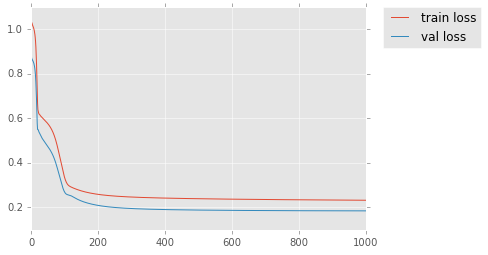

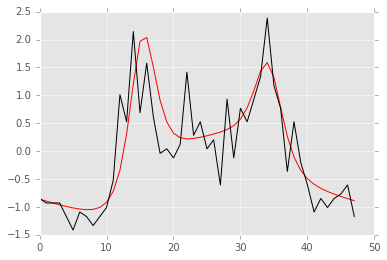

In [97]:
epoch = range(1000)
plt.figure()
plt.plot(epoch, train_loss, label = 'train loss')
plt.plot(epoch, val_loss, label = 'val loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim((0,1.1))
npdata = newdata
output = lasagne.layers.get_output(network, inputs= npdata[288:336, 1].reshape(48,1,1)).eval()
prediction = np.zeros(shape = (48,3))
prediction[:, 0:2] = olddata[2016:2064, 0:2]
prediction[:,2] = output.reshape(48)

plt.figure()
plt.plot(prediction[0:48,2], color = 'r')
plt.plot(npdata[288:336, -1], color = 'k')
#plt.bar(olddata[2016:2064, -1])

### Encode data:
    1. min-max normalise time
    2. mini-max normalise the count of accident
    3. one-hot encode weekday

In [78]:
olddata1 = np.load('data4/num_accident_2009-2015.npy')
olddata2 = np.load('data4/num_accident_tri_OHweekday_2009-2015.npy')
newdata = np.zeros(shape = (2352, 9))
newdata[:, 0:6] = olddata2[:,0:6]
newdata[:, 7] = (olddata1[:,1] - 0.5)/23.5
mini = olddata1[:,2].min()
count_range = olddata1[:,2].ptp()
print (mini)
print (count_range)
newdata[:, 8] = (olddata1[:,2] - mini)/6.7
np.save('data4/num_accident_OH_minmax_2009-2015.npy', newdata)

0.0
77.0


In [4]:
# Abstract Monday data
olddata = np.load('data4/num_accident_OH_minmax_2009-2015.npy')
newdata = np.zeros(shape = (336,2))
i = 48
j = 0
while j<7:
    newdata[j*48:j*48+48, :] = olddata[i:i+48, -2:]
    j+=1
    i+=336

In [82]:
def load_dataset():
    npdata = newdata
    npdata = npdata.astype(np.float32)
    X_train, X_val = npdata[0:240, 0].reshape(240,1,1), npdata[240:288, 0].reshape(48,1,1)
    y_train, y_val = npdata[0:240, -1].reshape(240,1), npdata[240:288, -1].reshape(48,1)
    x_test, y_test = npdata[288:336, 0].reshape(48,1,1), npdata[288:336, -1].reshape(48,1)
    #print (X_train.shape, y_train.shape, X_val.shape, y_val.shape, npdata.shape)
    return X_train, y_train, X_val, y_val, x_test, y_test


def build_mlp(input_var=None, units = 15, num_features = 1):
    
    # Input layer, specifying the expected input shape of the network
    l_in = lasagne.layers.InputLayer(shape=(None,1,num_features),
                                     input_var=input_var)

    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.LSTMLayer(
            l_in, num_units = units)
    
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
    l_hid3 = lasagne.layers.DenseLayer(
            l_hid2, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
      
    l_out = lasagne.layers.DenseLayer(
            l_hid3, num_units=1,
            nonlinearity=lasagne.nonlinearities.linear)

    return l_out


network, train_loss, val_loss = train_mlp(num_epochs=1000, learning_rate=0.02, train_shuffle = False, batchsize = 48)

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 1000 took 0.009s
  training loss:		6.139401
  validation loss:		3.892240
Epoch 2 of 1000 took 0.007s
  training loss:		3.816957
  validation loss:		3.063096
Epoch 3 of 1000 took 0.007s
  training loss:		3.605939
  validation loss:		3.021451
Epoch 4 of 1000 took 0.007s
  training loss:		3.580828
  validation loss:		2.988126
Epoch 5 of 1000 took 0.007s
  training loss:		3.516831
  validation loss:		2.995442
Epoch 6 of 1000 took 0.007s
  training loss:		3.533132
  validation loss:		2.992944
Epoch 7 of 1000 took 0.007s
  training loss:		3.535713
  validation loss:		2.989932
Epoch 8 of 1000 took 0.007s
  training loss:		3.529125
  validation loss:		2.991457
Epoch 9 of 1000 took 0.007s
  training loss:		3.530981
  validation loss:		2.991261
Epoch 10 of 1000 took 0.007s
  training loss:		3.531423
  validation loss:		2.990853
Epoch 11 of 1000 took 0.007s
  training loss:		3.530583
  validation loss:		2.99

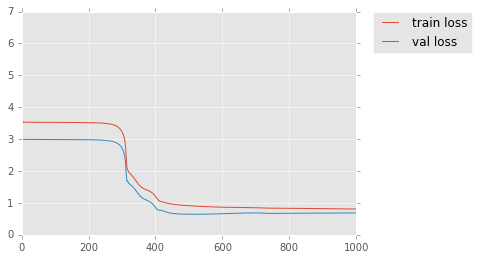

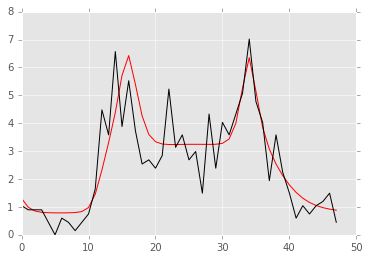

In [83]:
epoch = range(1000)
plt.figure()
plt.plot(epoch, train_loss, label = 'train loss')
plt.plot(epoch, val_loss, label = 'val loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim((0,1.1))
npdata = newdata
output = lasagne.layers.get_output(network, inputs= npdata[288:336, 0].reshape(48,1,1)).eval()
prediction = np.zeros(48)
prediction = output.reshape(48)

plt.figure()
plt.plot(prediction, color = 'r')
plt.plot(npdata[288:336, -1], color = 'k')
#plt.bar(olddata[2016:2064, -1])

/Users/XueqiWang/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


test loss:			0.829422876864


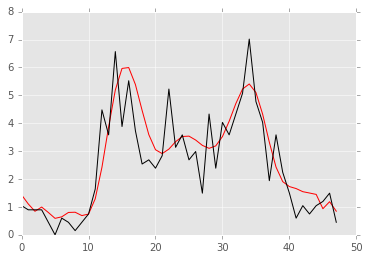

In [5]:
npdata = newdata
x = npdata[0:288, 0]
y = npdata[0:288, 1]
z = np.polyfit(x, y, 25)
fitline = np.poly1d(z)

plt.figure()
plt.plot(fitline(npdata[288:336, 0]), color = 'r')
plt.plot(npdata[288:336, -1], color = 'k')

# compute test loss
pre = fitline(npdata[288:336, 0])
ob = npdata[288:336, -1]
test_err = (pre - ob)**2
test_err = np.mean(test_err)
print ('test loss:\t\t\t{}'.format(test_err))